<a href="https://colab.research.google.com/github/jgabrielg99/Python/blob/main/Project_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

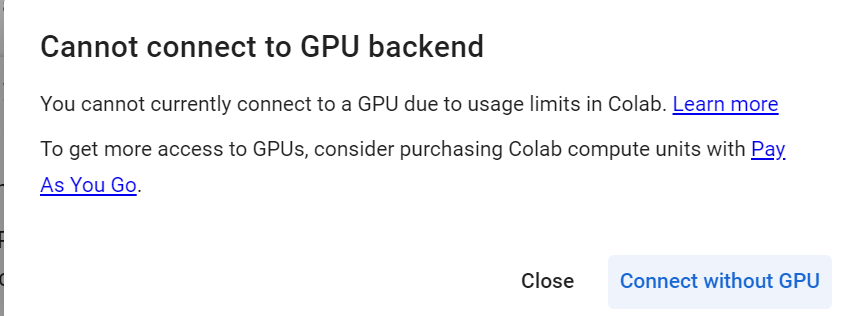

## **Installing and Importing Necessary Libraries**

In [ ]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import time

import json

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

import torch
from sentence_transformers import SentenceTransformer

from tqdm import tqdm
tqdm.pandas()


## **Loading the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/AIML Course/Files/stock_news.csv')

In [ ]:
df = data.copy()

## **Data Overview**

In [ ]:
df.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [ ]:
df.shape

(349, 8)

* There are 349 rows and 8 columns in this dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


* There are 2 object features and 6 numerical features
  * Date should be converted to Date Time

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,349,2019-02-16 16:05:30.085959936,2019-01-02 00:00:00,2019-01-14 00:00:00,2019-02-05 00:00:00,2019-03-22 00:00:00,2019-04-30 00:00:00,NaN
Open,349.0,46.229233,37.567501,41.740002,45.974998,50.7075,66.817497,6.442817
High,349.0,46.700458,37.817501,42.244999,46.025002,50.849998,67.0625,6.507321
Low,349.0,45.745394,37.305,41.482498,45.639999,49.7775,65.862503,6.391976
Close,349.0,44.926317,36.254131,40.246914,44.596924,49.11079,64.805229,6.398338
Volume,349.0,128948236.103152,45448000.0,103272000.0,115627200.0,151125200.0,244439200.0,43170314.918964
Label,349.0,-0.054441,-1.0,-1.0,0.0,0.0,1.0,0.715119


* The numerical features [Open, High, Low, and Close] all have very similar stats ranging. They are very highly correlated

In [ ]:
df.duplicated().sum()

0

* No duplicated rows

In [ ]:
df.isna().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


* No null values

## **Exploratory Data Analysis**

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

In [ ]:
df.columns

Index(['Date', 'News', 'Open', 'High', 'Low', 'Close', 'Volume', 'Label'], dtype='object')

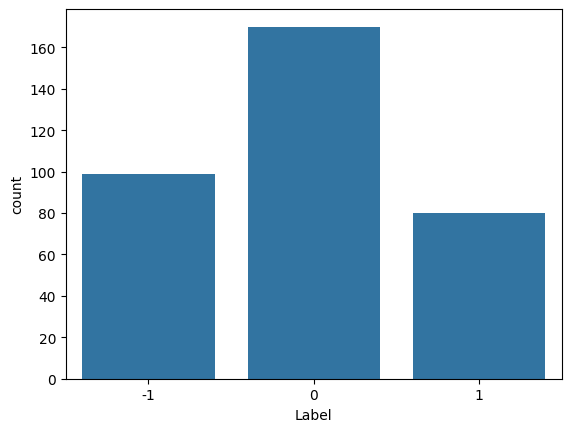

In [ ]:
sns.countplot(data=df, x='Label');

*There approximately 100 articles with negative sentiment; 170 articles with neutral sentiment, and 80 articles with positive sentiment


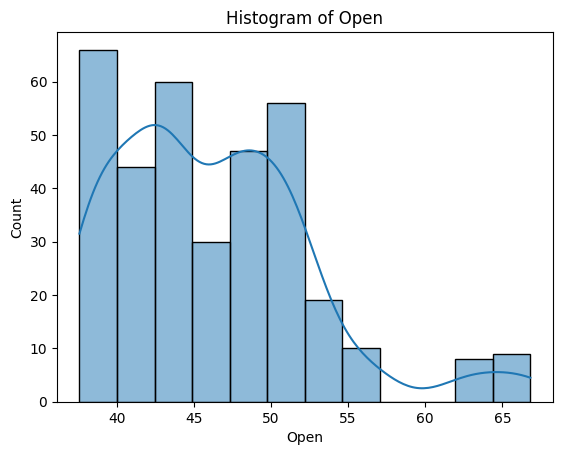

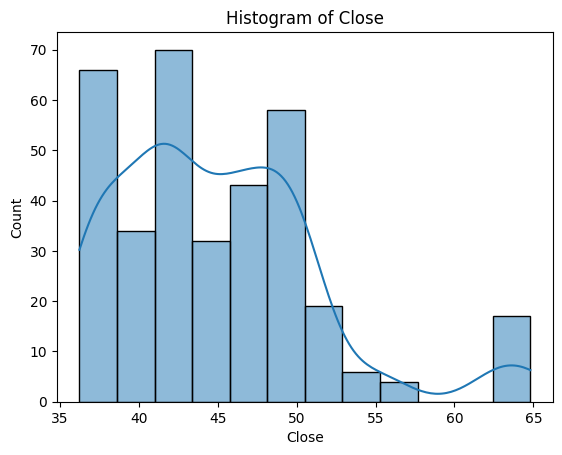

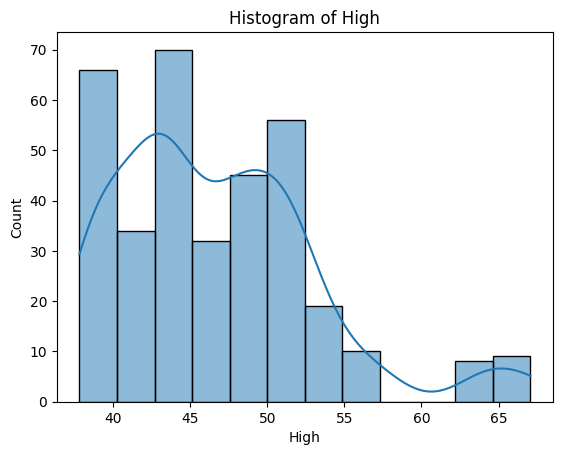

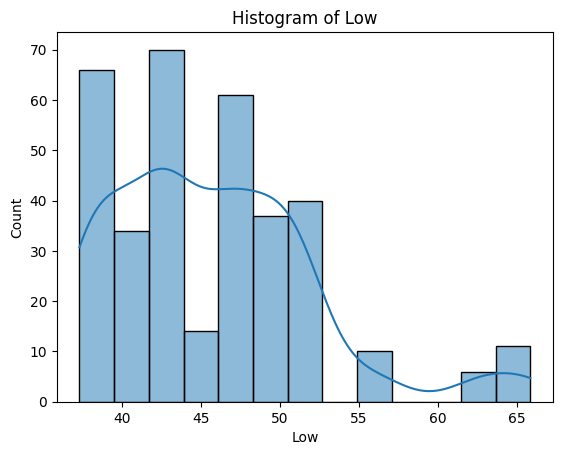

In [ ]:
for col in ['Open', 'Close', 'High', 'Low']:
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Histogram of {col}')
    plt.show()

*These 4 features are very similar

*The data is very right skewed

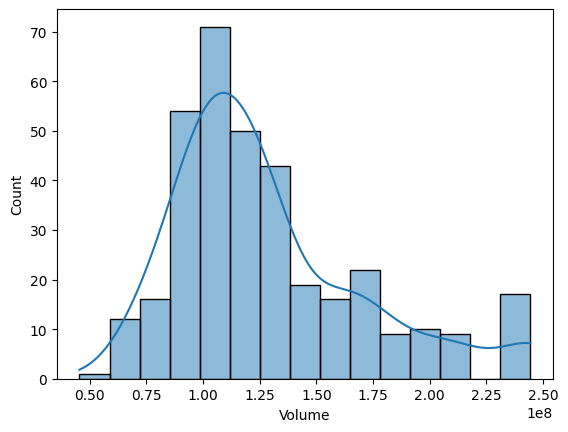

In [ ]:
sns.histplot(data=df, x='Volume', kde=True);

* Volume is unimodal and slightly skewed to the right

In [ ]:
df['news_length']=df['News'].apply(lambda x: len(x.split()))
df['news_length'].describe().T

,news_length
count,349.000000
mean,48.349570
std,5.717324
min,18.000000
25%,45.000000
50%,49.000000
75%,52.000000
max,60.000000


* The average news article is 48 tokens long
  * The max length in this dataset is 60 tokens

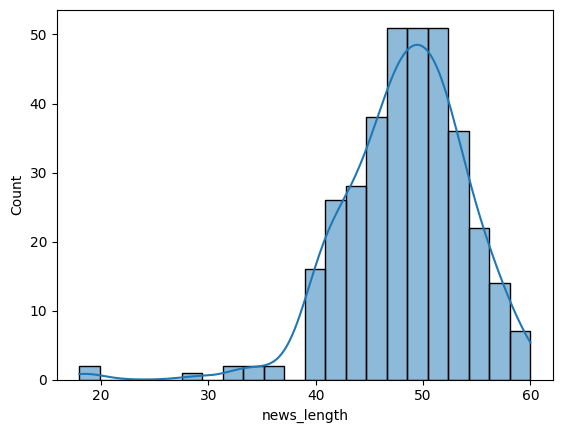

In [ ]:
sns.histplot(data=df, x='news_length', kde=True);

* News length is very left skewed and unimodal
  * The vast majority of articles are between 40 and 60 tokens long
  * Some articles are as short as 20 tokens

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

In [ ]:
df.columns

Index(['Date', 'News', 'Open', 'High', 'Low', 'Close', 'Volume', 'Label',
       'news_length'],
      dtype='object')

In [ ]:
num_cols = df.select_dtypes(include=np.number).columns

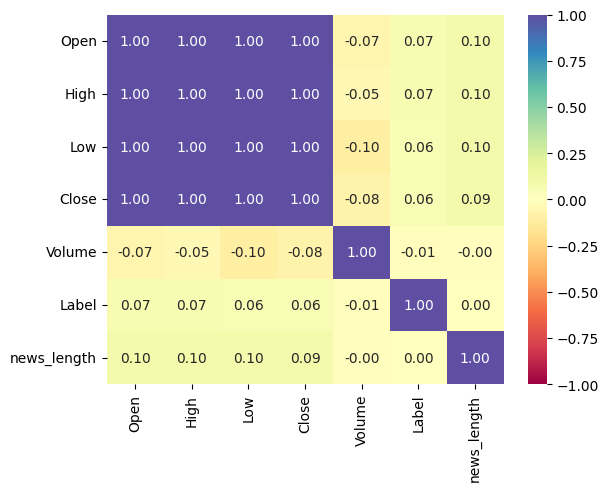

In [ ]:
sns.heatmap(df[num_cols].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap='Spectral');

* As expected, Open, High, Low, and Close are extremely highly correlated.
  * Otherwise, there are no other values of note

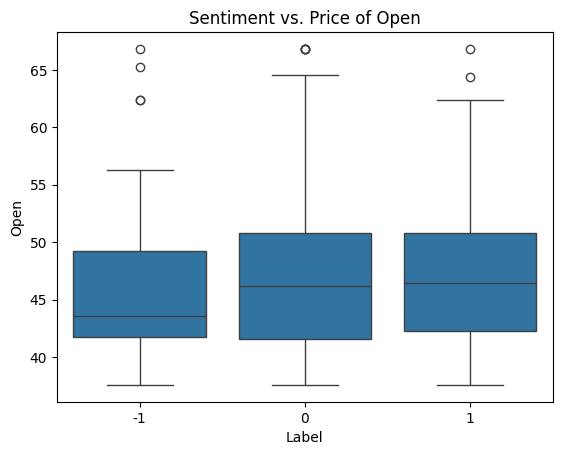

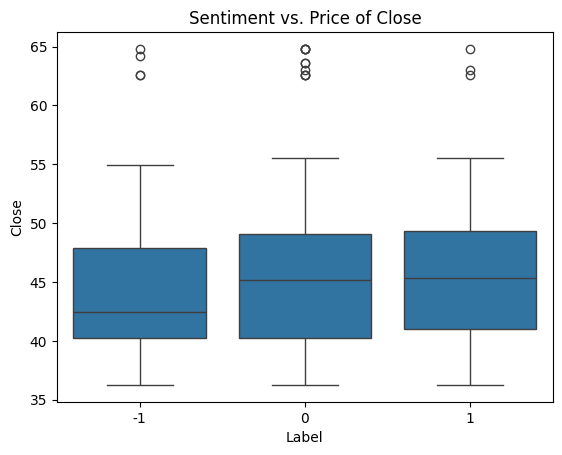

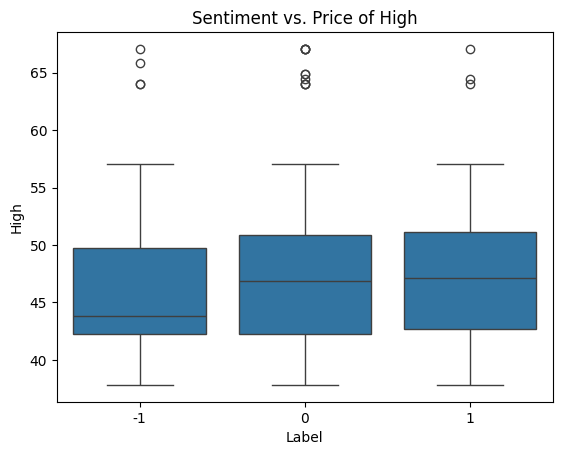

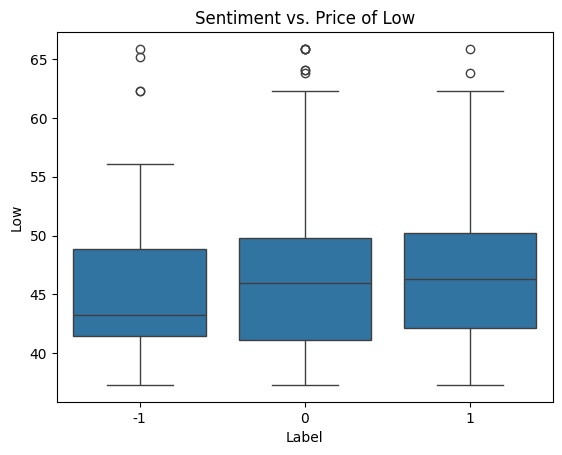

In [ ]:
for col in ['Open', 'Close', 'High', 'Low']:
    sns.boxplot(data=df, x='Label', y=col)
    plt.title(f'Sentiment vs. Price of {col}')
    plt.show()

* Articles with negative sentiment tend to have a slightly lower average price in all instances
* Article with positive sentiment *don't* tend to have a higher price than neutral sentiment

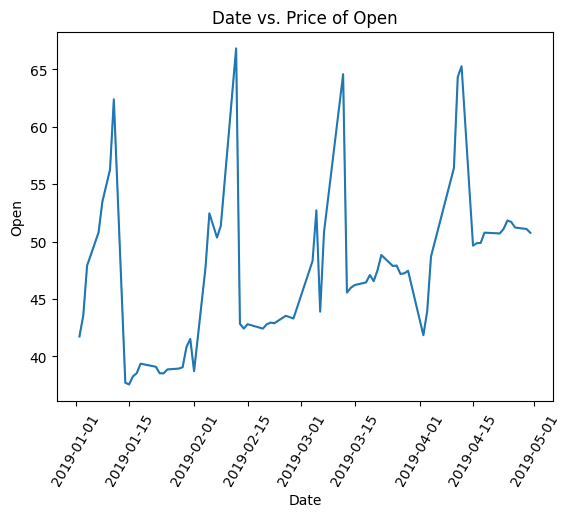

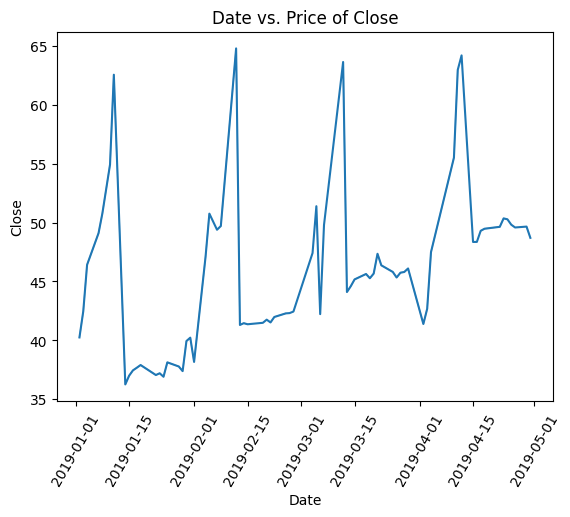

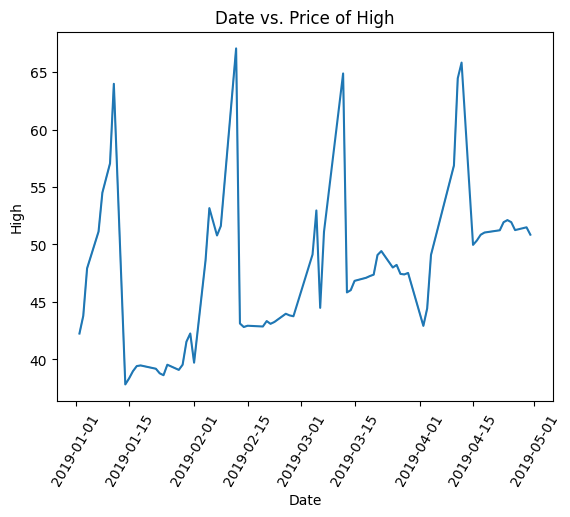

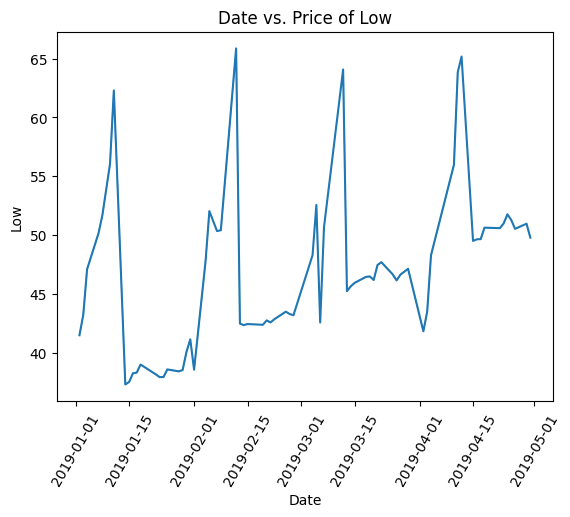

In [ ]:
for col in ['Open', 'Close', 'High', 'Low']:
    sns.lineplot(data=df, x='Date', y=col)
    plt.title(f'Date vs. Price of {col}')
    plt.xticks(rotation=60)
    plt.show()

* The overall trend is an increase in price over time

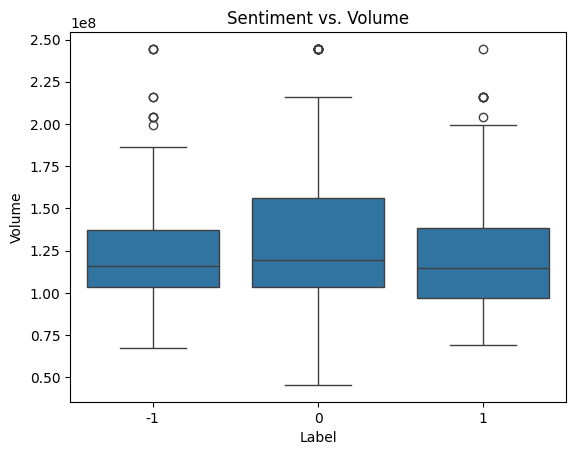

In [ ]:
sns.boxplot(data=df, x='Label', y='Volume')
plt.title('Sentiment vs. Volume')
plt.show()

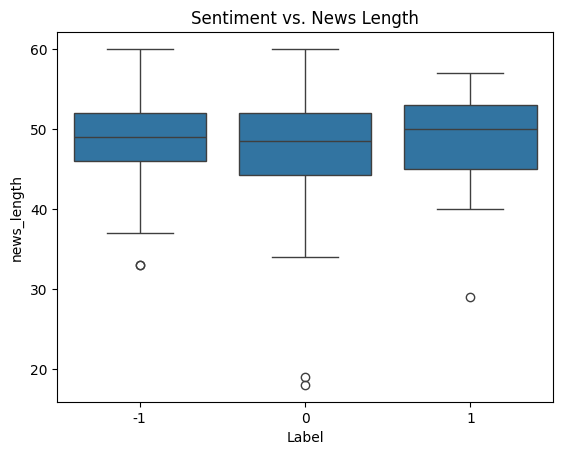

In [ ]:
sns.boxplot(data=df, x='Label', y='news_length')
plt.title('Sentiment vs. News Length')
plt.show()

* Positive sentiment articles tend to be slightly longer

## **Data Preprocessing**

In [ ]:
# Defining independent and target variables
X = df.drop(columns=['Label'])
y = df['Label']

# Splitting data into big and test sets
X_big, X_test, y_big, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [ ]:
# Splitting big set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_big, y_big, test_size=0.2, stratify=y_big, random_state=1)

In [ ]:
# Checking shape to training, validation, and test sets
print(f' X_train: {X_train.shape} X_val: {X_val.shape} X_test: {X_test.shape}')
print(f' y_train: {y_train.shape[0]} y_val: {y_val.shape[0]} y_test: {y_test.shape[0]}')

 X_train: (223, 8) X_val: (56, 8) X_test: (70, 8)
 y_train: 223 y_val: 56 y_test: 70


## **Word Embeddings**

### Word2Vec

In [ ]:
# Creating a list of all words in our data
words_list = [item.split(' ') for item in df['News'].values]

In [ ]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size=vec_size, min_count=2, window=5, workers=6)

In [ ]:
# Checking the size of the vocabulary
print('Length of the vocabulary is', len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 1781


In [ ]:
# Checking the word embedding of a random word
word = 'stock'
model_W2V.wv[word]

array([-0.01241809,  0.10626643,  0.01069313,  0.06813204,  0.00607253,
       -0.17612429,  0.05972576,  0.25258875,  0.0123966 , -0.03423057,
        0.02031338, -0.1075094 ,  0.02533815,  0.05225902, -0.11189134,
       -0.09073095,  0.06973494,  0.01446729, -0.00108901, -0.02655866,
       -0.08084489, -0.05736084,  0.13460885,  0.02962013,  0.10693201,
        0.02190865, -0.12896489,  0.04804377, -0.1354179 , -0.12104168,
        0.10572611, -0.08920623,  0.02274883, -0.02248872, -0.0238378 ,
        0.06229068,  0.0695402 , -0.13379289, -0.03099704, -0.00571885,
       -0.03058663, -0.00800146,  0.02750007, -0.11079241,  0.07833628,
        0.14886288,  0.00445757,  0.03172482, -0.04514768,  0.08670524,
        0.03944364,  0.03020792, -0.07501844,  0.04878695, -0.0307379 ,
        0.084223  ,  0.03201486,  0.00611572,  0.01380532, -0.0198285 ,
       -0.02247485, -0.02855502,  0.00317994,  0.07445157,  0.00451929,
        0.05306075, -0.01127914,  0.03027333, -0.07096945, -0.04

In [ ]:
# Checking the word embedding of a random word
word = 'market'
model_W2V.wv[word]

array([-0.01613072,  0.10071875,  0.00952009,  0.07078723,  0.0033058 ,
       -0.17151581,  0.05936769,  0.24569874,  0.00788174, -0.02842752,
        0.01800646, -0.10222879,  0.02360215,  0.049767  , -0.10800671,
       -0.08895293,  0.0689634 ,  0.01113071, -0.00110967, -0.02642762,
       -0.07892186, -0.05981841,  0.13130865,  0.02479182,  0.10976676,
        0.01646158, -0.12945104,  0.05036256, -0.1329483 , -0.1193062 ,
        0.10366819, -0.08170698,  0.02397567, -0.01777617, -0.02619018,
        0.0587108 ,  0.06949685, -0.13071002, -0.03440614, -0.0043688 ,
       -0.03084931, -0.01027523,  0.03277836, -0.10810265,  0.07597391,
        0.14470518, -0.00151146,  0.02857218, -0.04562598,  0.0881366 ,
        0.03491579,  0.0331388 , -0.07033665,  0.04695539, -0.02793377,
        0.07801068,  0.03516118,  0.00835228,  0.01258898, -0.01540872,
       -0.02678741, -0.02517362,  0.00538681,  0.07006334, -0.00051071,
        0.05030235, -0.01163934,  0.02951   , -0.06784957, -0.04

In [ ]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [ ]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# Creating a dataframe of the vecorized documents
X_train_wv = pd.DataFrame(X_train['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_wv = pd.DataFrame(X_val['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

In [ ]:
X_train_wv.head()

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 290,Feature 291,Feature 292,Feature 293,Feature 294,Feature 295,Feature 296,Feature 297,Feature 298,Feature 299
0,-0.015078,0.108169,0.009520,0.074338,0.002915,-0.180085,0.062166,0.262627,0.009628,-0.032598,...,0.003021,0.160163,0.145535,0.024744,0.187296,0.229416,0.031034,-0.029988,0.084289,-0.044150
1,-0.012725,0.095352,0.007435,0.066137,0.002562,-0.159211,0.054774,0.233078,0.008830,-0.028540,...,0.003728,0.141748,0.128920,0.021686,0.165808,0.203051,0.026437,-0.026638,0.074443,-0.038164
2,-0.015031,0.111496,0.009321,0.077305,0.002698,-0.185960,0.063756,0.270370,0.010208,-0.033605,...,0.003543,0.164659,0.150117,0.024978,0.193515,0.237002,0.031783,-0.030956,0.086992,-0.045803
3,-0.013532,0.097308,0.008156,0.067145,0.001916,-0.162724,0.056419,0.237778,0.009572,-0.029499,...,0.002866,0.144465,0.132076,0.022758,0.169299,0.207402,0.027853,-0.027276,0.075888,-0.039850
4,-0.013593,0.101132,0.008457,0.070021,0.002281,-0.169158,0.058824,0.246995,0.009223,-0.030702,...,0.002846,0.150580,0.136588,0.022925,0.175499,0.216508,0.028988,-0.027985,0.078886,-0.041846


### GloVe

In [ ]:
# load the Stanford GloVe model
glove_input_file = '/content/drive/MyDrive/AIML Course/Files/glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(glove_input_file, binary=False)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


In [ ]:
# Checking the word embedding of a random word
word = 'sell'
glove_model[word]

array([ 0.54884  ,  0.17591  , -0.035044 ,  0.17469  ,  0.20164  ,
       -0.28594  , -0.23911  , -0.06606  ,  0.14572  ,  0.0056116,
        0.25059  ,  0.25699  , -0.010374 , -0.28326  , -0.068809 ,
       -0.33683  ,  0.4391   ,  0.7344   ,  0.35816  ,  0.5177   ,
        0.63368  , -0.1474   ,  0.063402 ,  0.015441 , -0.37687  ,
       -0.30607  , -0.19169  , -0.2609   , -0.22938  ,  0.17054  ,
        0.18517  ,  0.78165  , -0.52568  , -0.42633  ,  0.078801 ,
        0.95789  ,  0.65904  , -0.49668  , -0.25009  , -0.77505  ,
        0.80428  , -0.21844  , -0.43629  , -0.99516  , -0.41962  ,
        0.32221  , -0.3157   , -0.31059  , -0.030167 , -1.0365   ,
       -0.01346  ,  0.64684  , -0.090937 ,  0.30308  ,  0.078578 ,
       -1.9397   , -0.68116  , -0.2414   ,  2.089    , -0.2909   ,
        0.63009  ,  0.46385  , -0.082429 ,  0.096444 ,  0.32551  ,
       -0.20024  ,  0.80637  ,  1.0036   ,  0.19504  , -0.72262  ,
        0.041356 , -0.26444  , -0.39471  , -0.092345 , -0.2570

In [ ]:
# Checking the word embedding of a random word
word = 'market'
glove_model[word]

array([ 0.39093  ,  0.23755  ,  0.44855  ,  0.11237  , -0.25996  ,
       -1.2248   , -0.44237  , -0.53491  ,  0.37142  , -0.61981  ,
       -0.27387  , -0.032213 ,  0.082629 , -0.52986  ,  0.13012  ,
        0.21703  , -0.45026  , -0.0048895,  0.34887  , -0.26069  ,
        0.56598  , -0.36219  ,  0.41926  ,  0.23441  , -0.29407  ,
       -0.27044  ,  0.29339  , -0.73905  , -0.75965  ,  0.64661  ,
       -0.038757 ,  0.38495  , -0.32314  ,  0.040322 ,  0.24036  ,
        0.35167  ,  0.47404  ,  0.014959 ,  0.12105  , -1.0398   ,
        0.27639  , -1.3785   , -0.22851  , -0.098074 ,  0.1495   ,
       -0.2815   ,  0.31682  , -0.10208  , -0.08586  , -1.5114   ,
       -0.48255  ,  0.15131  ,  0.0080133,  0.74594  , -0.20163  ,
       -2.5268   , -0.82083  ,  0.1143   ,  2.4665   ,  0.19841  ,
        0.1146   ,  0.10083  , -0.60936  ,  0.76722  ,  0.025978 ,
       -0.036936 ,  0.46744  , -0.77073  ,  0.83992  , -0.032931 ,
       -0.13127  , -0.097367 , -0.42634  , -0.49478  , -0.4079

In [ ]:
# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Creating a dictionary of words and their corresponding vectors
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [ ]:
vec_size=100

In [ ]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # Adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# Creating a dataframe of the vectorized documents
X_train_gl = pd.DataFrame(X_train['News'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_gl = pd.DataFrame(X_val['News'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_gl = pd.DataFrame(X_test['News'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

In [ ]:
print(X_train_gl.shape, X_val_gl.shape, X_test_gl.shape)

(223, 100) (56, 100) (70, 100)


### Sentence Transformer

In [ ]:
# Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
# Setting the device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Encoding the dataset
X_train_st = model.encode(X_train['News'].values, show_progress_bar=True, device=device)
X_val_st = model.encode(X_val['News'].values, show_progress_bar=True, device=device)
X_test_st = model.encode(X_test['News'].values, show_progress_bar=True, device=device)

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print(X_train_st.shape, X_val_st.shape, X_test_st.shape)

(223, 384) (56, 384) (70, 384)


## **Sentiment Analysis**

### **A Model can make a wrong prediction in the following ways:**
1. Predicts an article is positive in sentiment when the article is actually neutral or negative (false positive)
2. Predicts an article is negative in sentiment when the article is actually neutral or postive (false negative)
3. Predicts and article is neutral in sentiment when the article is actually positive or negative

###**Which case is more important?**
In this case, as both false positive *and* false negatives can be detrimental to analyzing stock price predictions and optimizing investment strategies, it will be valuable to prioritize minimizing both incorrect categories of incorrect predictions

###**How to reduce this loss?**
In order to reduce the number of false positive and negative predictions, we will need to minimize the F1 score of the model.

In [ ]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1,-1]  # Define the labels for the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.

In [ ]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

### Word2Vec Model

In [ ]:
# Building the model

wv_model = RandomForestClassifier(random_state=1)

wv_model.fit(X_train_wv, y_train)

RandomForestClassifier(random_state=1)

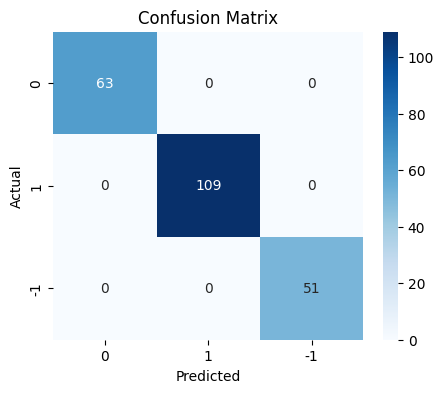

In [ ]:
plot_confusion_matrix(wv_model, X_train_wv, y_train)

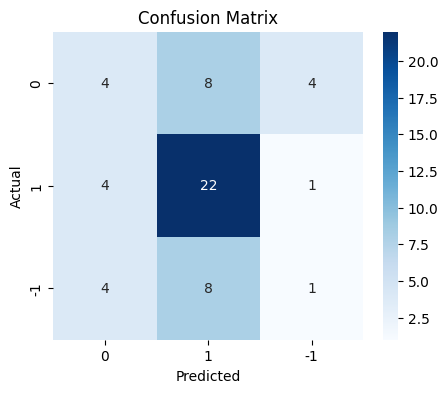

In [ ]:
plot_confusion_matrix(wv_model, X_val_wv, y_val)

* The Word2Vec model tends to predict that most articles are positive, so it missed most of the neutral and negative sentiment in the articles

In [ ]:
wv_model_train = model_performance_classification_sklearn(wv_model, X_train_wv, y_train)
wv_model_val = model_performance_classification_sklearn(wv_model, X_val_wv, y_val)

In [ ]:
wv_model_train

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [ ]:
wv_model_val

,Accuracy,Recall,Precision,F1
0,0.482143,0.482143,0.413064,0.432442


*As expected from the confusion matrix, the model overfits quite a bit

### GloVe Model

In [ ]:
gl_model = RandomForestClassifier(random_state=1)

gl_model.fit(X_train_gl, y_train)

RandomForestClassifier(random_state=1)

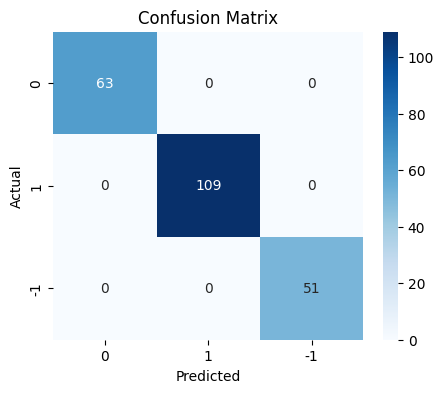

In [ ]:
plot_confusion_matrix(gl_model, X_train_gl, y_train)

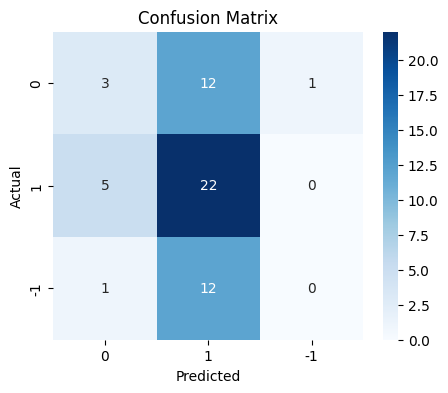

In [ ]:
plot_confusion_matrix(gl_model, X_val_gl, y_val)

* The GloVe model also severely overpredicted the number of positive articles; this may be due to the class imbalance between the number of articles present in each class
* The GloVe model struggled to predict negative value more than Word2Vec

In [ ]:
gl_model_train = model_performance_classification_sklearn(gl_model, X_train_gl, y_train)
gl_model_val = model_performance_classification_sklearn(gl_model, X_val_gl, y_val)

In [ ]:
gl_model_train

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [ ]:
gl_model_val

,Accuracy,Recall,Precision,F1
0,0.446429,0.446429,0.325828,0.359178


* The GloVe model performs worse than the Word2Vec model

### Sentence Transformer Model

In [ ]:
st_model = RandomForestClassifier(random_state=1)

st_model.fit(X_train_st, y_train)

RandomForestClassifier(random_state=1)

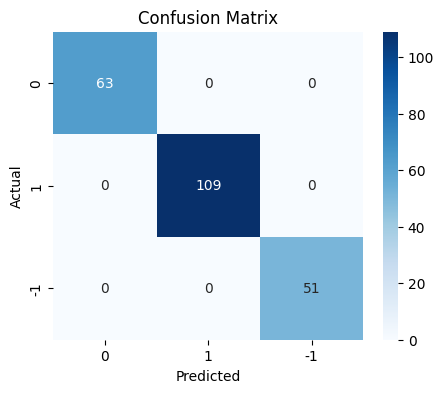

In [ ]:
plot_confusion_matrix(st_model, X_train_st, y_train)

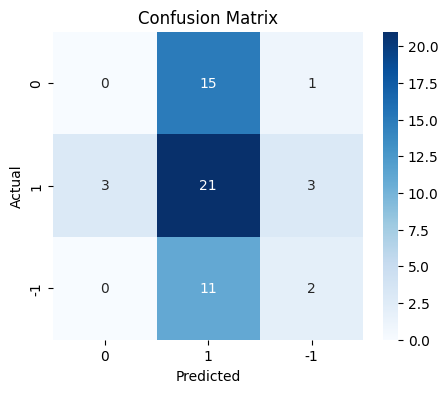

In [ ]:
plot_confusion_matrix(st_model, X_val_st, y_val)

* Once again, the model overpredicted the number of positive articles.
  * This model struggled to predict neutral sentiment

In [ ]:
st_model_train = model_performance_classification_sklearn(st_model, X_train_st, y_train)
st_model_val = model_performance_classification_sklearn(st_model, X_val_st, y_val)

In [ ]:
st_model_train

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [ ]:
st_model_val

,Accuracy,Recall,Precision,F1
0,0.410714,0.410714,0.292806,0.322521


* This model severely overfits

### Tuned Word2Vec Model

In [ ]:
wv_tuned = RandomForestClassifier(random_state=1)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5, 12, 2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

grid_obj = GridSearchCV(wv_tuned, parameters, scoring='f1_weighted', cv=5, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_wv, y_train)

wv_tuned = grid_obj.best_estimator_

In [ ]:
wv_tuned.fit(X_train_wv, y_train)

RandomForestClassifier(max_depth=6, max_features=0.2, min_samples_split=9,
                       random_state=1)

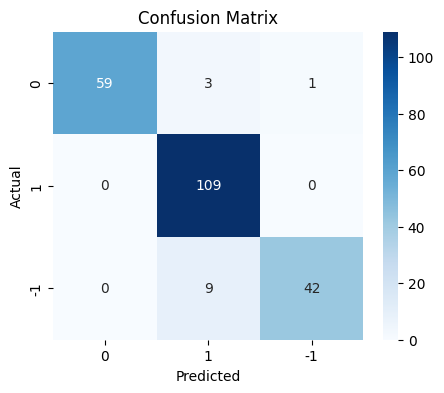

In [ ]:
plot_confusion_matrix(wv_tuned, X_train_wv, y_train)

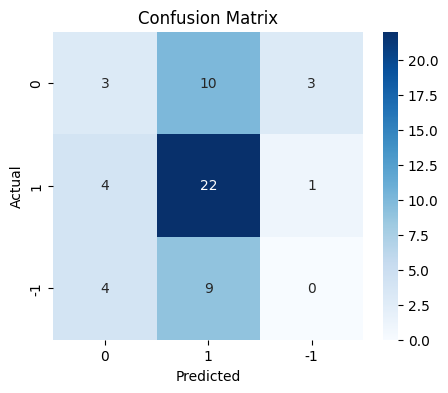

In [ ]:
plot_confusion_matrix(wv_tuned, X_val_wv, y_val)

In [ ]:
wv_tuned_train = model_performance_classification_sklearn(wv_tuned, X_train_wv, y_train)
wv_tuned_val = model_performance_classification_sklearn(wv_tuned, X_val_wv, y_val)

In [ ]:
wv_tuned_train

,Accuracy,Recall,Precision,F1
0,0.941704,0.941704,0.946206,0.940906


In [ ]:
wv_tuned_val

,Accuracy,Recall,Precision,F1
0,0.446429,0.446429,0.336633,0.375467


* The tuned Word2Vec model still overpredicts the number of positive articles and is quite overfit

### Tuned GloVe Model

In [ ]:
gl_tuned = RandomForestClassifier(random_state=1)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5, 12, 2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

grid_obj = GridSearchCV(gl_tuned, parameters, scoring='f1_weighted', cv=5, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_gl, y_train)

gl_tuned = grid_obj.best_estimator_

In [ ]:
gl_tuned.fit(X_train_gl, y_train)

RandomForestClassifier(max_depth=6, max_features=0.4, min_samples_split=7,
                       random_state=1)

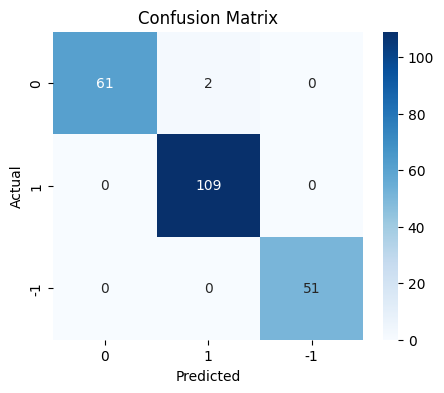

In [ ]:
plot_confusion_matrix(gl_tuned, X_train_gl, y_train)

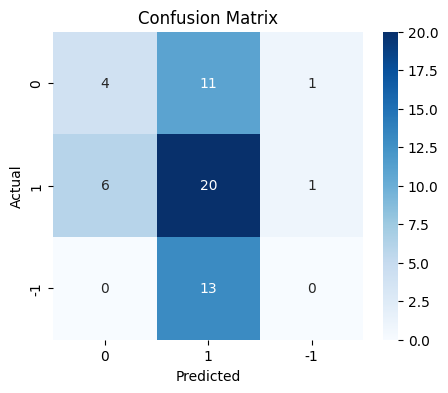

In [ ]:
plot_confusion_matrix(gl_tuned, X_val_gl, y_val)

In [ ]:
gl_tuned_train = model_performance_classification_sklearn(gl_tuned, X_train_gl, y_train)
gl_tuned_val = model_performance_classification_sklearn(gl_tuned, X_val_gl, y_val)

In [ ]:
gl_tuned_train

,Accuracy,Recall,Precision,F1
0,0.991031,0.991031,0.991193,0.991


In [ ]:
gl_tuned_val

,Accuracy,Recall,Precision,F1
0,0.428571,0.428571,0.333442,0.359542


* The tuned model does not perform much better than the base GloVe model

### Tuned Sentence Transformer Model

In [ ]:
st_tuned = RandomForestClassifier(random_state=1)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

grid_obj = GridSearchCV(st_tuned, parameters, scoring='f1_weighted', cv=5, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_wv, y_train)

st_tuned = grid_obj.best_estimator_

In [ ]:
st_tuned.fit(X_train_st, y_train)

RandomForestClassifier(max_depth=6, max_features=0.2, min_samples_split=9,
                       random_state=1)

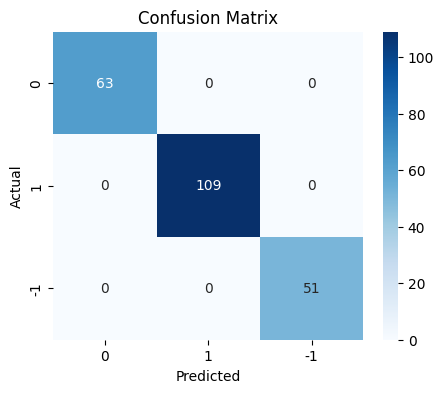

In [ ]:
plot_confusion_matrix(st_tuned, X_train_st, y_train)

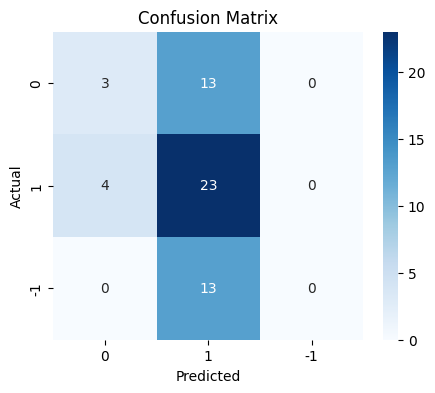

In [ ]:
plot_confusion_matrix(st_tuned, X_val_st, y_val)

In [ ]:
st_tuned_train = model_performance_classification_sklearn(st_tuned, X_train_st, y_train)
st_tuned_val = model_performance_classification_sklearn(st_tuned, X_val_st, y_val)

In [ ]:
st_tuned_train

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [ ]:
st_tuned_val

,Accuracy,Recall,Precision,F1
0,0.464286,0.464286,0.348761,0.366357


* The tuned Sentence Transformer model actually performs worse than the base model

### Model Comparison

In [ ]:
#training performance comparison

models_train_comp_df = pd.concat(
    [wv_model_train.T,
     gl_model_train.T,
     st_model_train.T,
     wv_tuned_train.T,
     gl_tuned_train.T,
     st_tuned_train.T,
    ],axis=1
)

models_train_comp_df.columns = [
    "Word2Vec Model",
    "GloVe Model",
    "Sentence Transformer Model",
    "Tuned Word2Vec Model",
    "Tuned GloVe Model",
    "Tuned Sentence Transformer Model",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Word2Vec Model,GloVe Model,Sentence Transformer Model,Tuned Word2Vec Model,Tuned GloVe Model,Tuned Sentence Transformer Model
Accuracy,1.0,1.0,1.0,0.941704,0.991031,1.0
Recall,1.0,1.0,1.0,0.941704,0.991031,1.0
Precision,1.0,1.0,1.0,0.946206,0.991193,1.0
F1,1.0,1.0,1.0,0.940906,0.991000,1.0


In [ ]:
#validation performance comparison

models_val_comp_df = pd.concat(
    [wv_model_val.T,
     gl_model_val.T,
     st_model_val.T,
     wv_tuned_val.T,
     gl_tuned_val.T,
     st_tuned_val.T,
    ],axis=1
)

models_val_comp_df.columns = [
    "Word2Vec Model",
    "GloVe Model",
    "Sentence Transformer Model",
    "Tuned Word2Vec Model",
    "Tuned GloVe Model",
    "Tuned Sentence Transformer Model",
]

print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Word2Vec Model,GloVe Model,Sentence Transformer Model,Tuned Word2Vec Model,Tuned GloVe Model,Tuned Sentence Transformer Model
Accuracy,0.482143,0.446429,0.410714,0.446429,0.428571,0.464286
Recall,0.482143,0.446429,0.410714,0.446429,0.428571,0.464286
Precision,0.413064,0.325828,0.292806,0.336633,0.333442,0.348761
F1,0.432442,0.359178,0.322521,0.375467,0.359542,0.366357


* All models struggle to correctly identify article sentiment and instead labels everything as positive. This leads to significant overfitting in all models
* The base Word2Vec model has the highest F1 score of all models

## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [ ]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python -q

In [ ]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/AIML Course/Files/stock_news.csv')

In [ ]:
df1 = data.copy()

#### Loading the model

In [ ]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

# Using hf_hub_download to download a model from the Hugging Face model hub
# The repo_id parameter specifies the model name or path in the Hugging Face repository
# The filename parameter specifies the name of the file to download
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

In [ ]:
llm = Llama(
    model_path=model_path, # Path to the model
    n_gpu_layers=100, #Number of layers transferred to GPU
    n_ctx=4500, #Context window
)

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loade

#### Aggregating the data weekly

In [ ]:
df1["Date"] = pd.to_datetime(df1['Date'])  # Convert the 'Date' column to datetime format.

In [ ]:
# Group the data by week using the 'Date' column.
weekly_grouped = df1.groupby(pd.Grouper(key='Date', freq='W'))

In [ ]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [ ]:
weekly_grouped

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...
5,2019-02-10,"The Dow Jones Industrial Average, S&P 500, an..."
6,2019-02-17,"This week, the European Union's second highes..."
7,2019-02-24,This news article discusses progress towards ...
8,2019-03-03,The Dow Jones Industrial Average and other ma...
9,2019-03-10,"Spotify, the world's largest paid music strea..."


In [ ]:
# creating a copy of the data
df1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [ ]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=1024, #Complete the code to set the maximum number of tokens the model should generate for this task.
      temperature=0, #Complete the code to set the value for temperature.
      top_p=0.95, #Complete the code to set the value for top_p
      top_k=50, #Complete the code to set the value for top_k
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

In [ ]:
news = df1.loc[0,'News']

In [ ]:
print(len(news.split(' ')))
news

2611


' The tech sector experienced a significant decline in the aftermarket following Apple\'s Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple\'s downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple\'s stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple\'s shares fell 8.5% in post market trading, while Asian suppliers like Hon ||  This news article reports that yields o

In [ ]:
# defining the instructions for the model
prompt = """
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news articles and provide the top three positive and negative events that are likely to affect stock prices.

Instructions:
1. Read the news articles.
2. Identify the 3 main positive events that are likely to affect stock prices.
3. Identify the 3 main negative events that are likely to affect stock prices.
4. Extract relevent keywords to describe the events in a concise manner
5. Return the output in JSON format with 2 keys, one for Positive Events and one for Negative Events.

"""

In [ ]:
summary = response_mistral_1(prompt, news)

llama_perf_context_print:        load time =  342793.87 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  3900 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   465 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  434235.78 ms /  4365 tokens


In [ ]:
print(summary)

 {
         "Positive Events": [
           {
             "Description": "Roku Inc announces plans to offer premium video channels on a subscription basis through its free streaming service, The Roku Channel. This follows Amazon's successful Channels business."
             "Keywords": ["Roku", "premium video channels", "subscription", "Amazon", "Channels"]
           },
           {
             "Description": "The Chinese central bank announces a fifth reduction in the required reserve ratio (RRR) for banks, freeing up approximately 116.5 billion yuan for new lending."
             "Keywords": ["Chinese central bank", "required reserve ratio", "RRR", "new lending"]
           },
           {
             "Description": "President Trump expresses optimism over potential trade talks with China, citing China's current economic weakness as a potential advantage for the US."
             "Keywords": ["President Trump", "trade talks", "China", "economic weakness"]
           }
         ],

##### Checking the model output on the weekly data

In [ ]:
df1['Key Events'] = df1['News'].progress_apply(lambda x: response_mistral_1(prompt,x))

  0%|          | 0/18 [00:00<?, ?it/s]Llama.generate: 3899 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =  342793.87 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   466 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   91887.32 ms /   467 tokens
 11%|█         | 2/18 [01:31<12:15, 45.95s/it]Llama.generate: 155 prefix-match hit, remaining 2234 prompt tokens to eval
llama_perf_context_print:        load time =  342793.87 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  2234 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   468 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  265951.83 ms /  2702 token

In [ ]:
df1["Key Events"].head()

,Key Events
0,"{\n ""Positive Events"": [\n ..."
1,"{\n ""Positive Events"": [\n ..."
2,"{\n ""Positive Events"": [\n ..."
3,"{\n ""Positive Events"": [\n ..."
4,"{\n ""Positive Events"": [\n ..."


##### Formatting the model output

In [ ]:
df1['model_response_parsed'] = df1['Key Events'].apply(extract_json_data)
df1.head()

Error parsing JSON: Expecting ',' delimiter: line 5 column 14 (char 275)


,Date,News,Key Events,model_response_parsed
0,2019-01-06,The tech sector experienced a significant dec...,"{\n ""Positive Events"": [\n ...",{}
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,"{\n ""Positive Events"": [\n ...",{'Positive Events': [{'Description': 'Sprint a...
2,2019-01-20,The U.S. stock market declined on Monday as c...,"{\n ""Positive Events"": [\n ...",{'Positive Events': [{'Description': 'Apple's ...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...","{\n ""Positive Events"": [\n ...",{'Positive Events': [{'Event': 'IBM's better-t...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,"{\n ""Positive Events"": [\n ...",{'Positive Events': [{'Event': 'Apple reported...


In [ ]:
model_response_parsed = pd.json_normalize(df1['model_response_parsed'])
model_response_parsed.head()

,Positive Events,Negative Events
0,NaN,NaN
1,[{'Description': 'Sprint and Samsung plan to r...,"[{'Description': 'Geely, China's most successf..."
2,[{'Description': 'Apple's partnership with TD ...,[{'Description': 'Unexpected drops in China's ...
3,[{'Event': 'IBM's better-than-expected earning...,[{'Event': 'Swiss National Bank's negative int...
4,[{'Event': 'Apple reported spending over $60 b...,[{'Event': 'Caterpillar Inc reported lower-tha...


In [ ]:
final_output = pd.concat([df1.reset_index(drop=True),model_response_parsed],axis=1)
final_output.drop(['Key Events','model_response_parsed'], axis=1, inplace=True)
final_output.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events']

final_output.head()

,Week End Date,News,Week Positive Events,Week Negative Events
0,2019-01-06,The tech sector experienced a significant dec...,NaN,NaN
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,[{'Description': 'Sprint and Samsung plan to r...,"[{'Description': 'Geely, China's most successf..."
2,2019-01-20,The U.S. stock market declined on Monday as c...,[{'Description': 'Apple's partnership with TD ...,[{'Description': 'Unexpected drops in China's ...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...",[{'Event': 'IBM's better-than-expected earning...,[{'Event': 'Swiss National Bank's negative int...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,[{'Event': 'Apple reported spending over $60 b...,[{'Event': 'Caterpillar Inc reported lower-tha...


## **Conclusions and Recommendations**

* The Random Forest Classifier models struggled to correctly predict article sentiment. Instead, the models tended to predict everything as positive sentiment.
* Perhaps further tuning of the Word2Vec, GloVe, and Sentence Transformer models will help detect sentiment
* Using Facebook's large Bart model, we were able to have the model identify the top 3 positive and negative events that are likely to affect stock prices.
* This capability may be valuable in providing actionable insight for investment strategies




<font size=6 color='blue'>Power Ahead</font>
___